## The ELAsTiCC "Starter Kit" - Overview and Quick Look
### Alex Gagliano, 07/25/2023 (gaglian2@illinois.edu)


(With material recycled from the PLAsTiCC Starter Kit at 
https://github.com/LSSTDESC/plasticc-kit/blob/master/plasticc_astro_starter_kit.ipynb!)

In [1]:
# You can edit the font size here to make rendered text more comfortable to read
# It was built on a 15" retina screen with 18px
from IPython.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 20px; }</style>"))

![](media/RubinObs.jpeg)
(Credit: LSST Corporation)

The Rubin Observatory's Legacy Survey of Space and Time is going to be revolutionary for time-domain astrophysics. Rubin is an 8-meter class telescope, which is not new, but its field of view is unprecedented for its class:

![](media/LSST_FoV.jpg)

(Credit: Zelko Ivezic, LSST)

Compare this with the field of view of the Hubble Space Telescope, outlined in white, relative to the full moon: 
    
![](media/HST_field_of_view.jpg)

Hubble observes a much smaller patch of sky than Rubin will, and collects light much more slowly. As a result, each and every week Rubin will find more transients than Hubble has ever seen _in its entire 30+ years of operation._

In this short demo, we're going to take a whirwind tour through some data from the Extended LSST Astronomical Time-Series Classification Challenge (ELAsTiCC). We'll look at what transients the Rubin is expected to find, and what properties these transients have that help us characterize them. 

Rubin hasn't come online yet, so we can't use real data! This simulation combines our best models for many different types of transients, and combines how Rubin will scan the sky every night and what contributes to the uncertainty in our measurements.

We'll begin by installing and importing some essential packages.

In [33]:
!pip install wget pandas numpy seaborn matplotlib astropy ephem

In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

from collections import Counter
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, w0wzCDM
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import ephem

The dataset we're importing is only 10% of the ELAsTiCC training set! The full training set can be found at https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset_elasticc2 (but it is much larger).

In [4]:
import wget 

remote_url = "https://uofi.box.com/shared/static/2c9w6uvrzelkbzgxy9zujbl3hw35rpsj.json"
name = "ELAsTiCC10pct_tutorial.json"
wget.download(remote_url, name)
df = pd.read_json(name)

100% [....................................................................] 1628192748 / 1628192748

For simplicity, we've saved the brightness measurements and the ancillary data (like the properties of the host galaxy) as one table in json format. This saves arrays as lists, but to manipulate these data we'll have to turn these back into arrays:

In [5]:
#we saved some json variables as a list, so we need to convert them back to arrays 
for col in ['MJD', 'Flux', 'Flux_Err', 'Flux', 'Mag', 'Mag_Err']:
    df[col] = [np.array(x, dtype=float) for x in df[col]]
for col in ['Band']:
    df[col] = [np.array(x) for x in df[col]]

Note that the dataset that we're using is the general Wide-Fast-Deep survey that Rubin will conduct. Another survey of Deep Drilling Fields will take place at much higher cadence. 

As we mentioned before, this photometry is obtained through _difference imaging_: We take the difference between two images at different dates, and if the flux has increased in a pixel between these two dates then the difference image will show a bright point. Here is an example of a reference (left), science (middle), and difference (right) image in R-band. 

<img src="media/DIA.png"  width="80%" height="40%">

(Credit: PLAsTiCC Starter Kit) 

This source will have a positive 'Flux' value at 2007-09-11. Because the eye's response to light is logarithmic in nature and not linear, however, we typically don't look at the raw flux of a source. We look at its _magnitude_, which is proportional to the base-10 log of its flux. We'll look at both in this tutorial. 

Let's first look at a few entries in the full dataframe:

In [6]:
df.sample(n=5)

,SNID,true_redshift,MWEBV,hostgal_ellipticity,discovery_date,RA,Dec,hostgal_photoz,hostgal_photoz_err,hostgal_logsfr,...,hostgal_mag_z,hostgal_mag_Y,MJD,Flux,Mag,Mag_Err,Flux_Err,Type,Band,T_FWHM
117490,26311140,0.949580,0.043908,-9999.0000,60968.085938,-999.000000,-999.000000,-9.000000,-9.00000,0.8896,...,999.000000,999.000000,"[60811.4158, 60825.4392, 60849.395, 60849.4139...","[4.0320472717, 3.7167770863, 0.6304242015, -2....","[25.9861869812, 26.0745830536, 28.0009174347, ...","[10.8796901703, 1.7544676065, 9.6159324646, -1...","[40.4047355652, 6.0062308311, 5.5836019516, 4....",SNIc+HostXT_V19,"[Y, r, i, r, z, z, Y, i, z, Y, i, z, r, r, i, ...",239.010933
112586,29874527,0.612775,0.160034,0.3400,61146.347656,226.291533,-30.470560,0.612775,0.04349,-0.0600,...,22.023661,21.796446,"[61099.3309, 61099.3486, 61101.3245, 61103.284...","[-2.7193348408, -12.5389842987, -5.0322523117,...","[nan, nan, nan, nan, nan, 24.618970871, nan, n...","[-3.7718224525, -1.5827125310999999, -3.219524...","[9.4472208023, 18.279088974, 14.9225940704, 11...",SNIc+HostXT_V19,"[z, Y, Y, i, z, Y, i, r, g, r, u, g, r, i, g, ...",117.143618
157188,49584738,0.303481,0.015164,0.0784,61084.285156,180.930079,0.978394,0.294504,0.03538,-0.7993,...,21.467518,21.325550,"[61055.3474, 61057.335, 61062.3711, 61065.3397...","[-9.7298088074, -8.8837661743, 8.6504821777, 1...","[nan, nan, 25.1573982239, 24.5515289307, 25.70...","[-0.8134450912000001, -1.2330243587, 1.1396982...","[7.2899188995, 10.0892515182, 9.0807209015, 3....",TDE,"[r, i, i, g, r, z, g, r, i, z, Y, r, i, u, g, ...",43.907519
69220,43248015,0.284231,0.021956,0.0969,60668.230469,120.521466,2.839059,0.284231,0.03482,NaN,...,21.481798,21.390182,"[60610.3724, 60614.3676, 60622.3562, 60625.352...","[11.3430538177, -12.2438325882, 3.5430340767, ...","[24.8631744385, nan, 26.1265621185, 26.0626144...","[0.9794311523, -0.7741215229, 1.3064339161, 1....","[10.2327899933, 8.7300491333, 4.2633690834, 5....",CART,"[i, i, r, i, z, z, r, i, r, i, Y, i, z, Y, z, ...",36.660164
145502,31904127,0.524286,0.021232,0.5687,61003.140625,68.929379,-38.514804,0.524286,0.04150,-0.4422,...,22.710939,22.539827,"[60897.4062, 60927.3771, 60957.3764, 60958.382...","[35.8234214783, -9.4408359528, 2.3546085358, -...","[23.6145820618, nan, 26.5702037811, nan, nan, ...","[0.9380144477000001, -1.3391170502, 5.89371585...","[30.9504318237, 11.6444540024, 12.7819776535, ...",SNIcBL+HostXT_V19,"[Y, z, z, z, r, i, r, i, Y, i, z, g, r, g, r, ...",20.387897


This is the training set, so the transient type is given. In reality, many of the algorithms we're developing for first light are oriented toward trying to figure out what we're looking at! For now, let's take a look at the class breakdown:

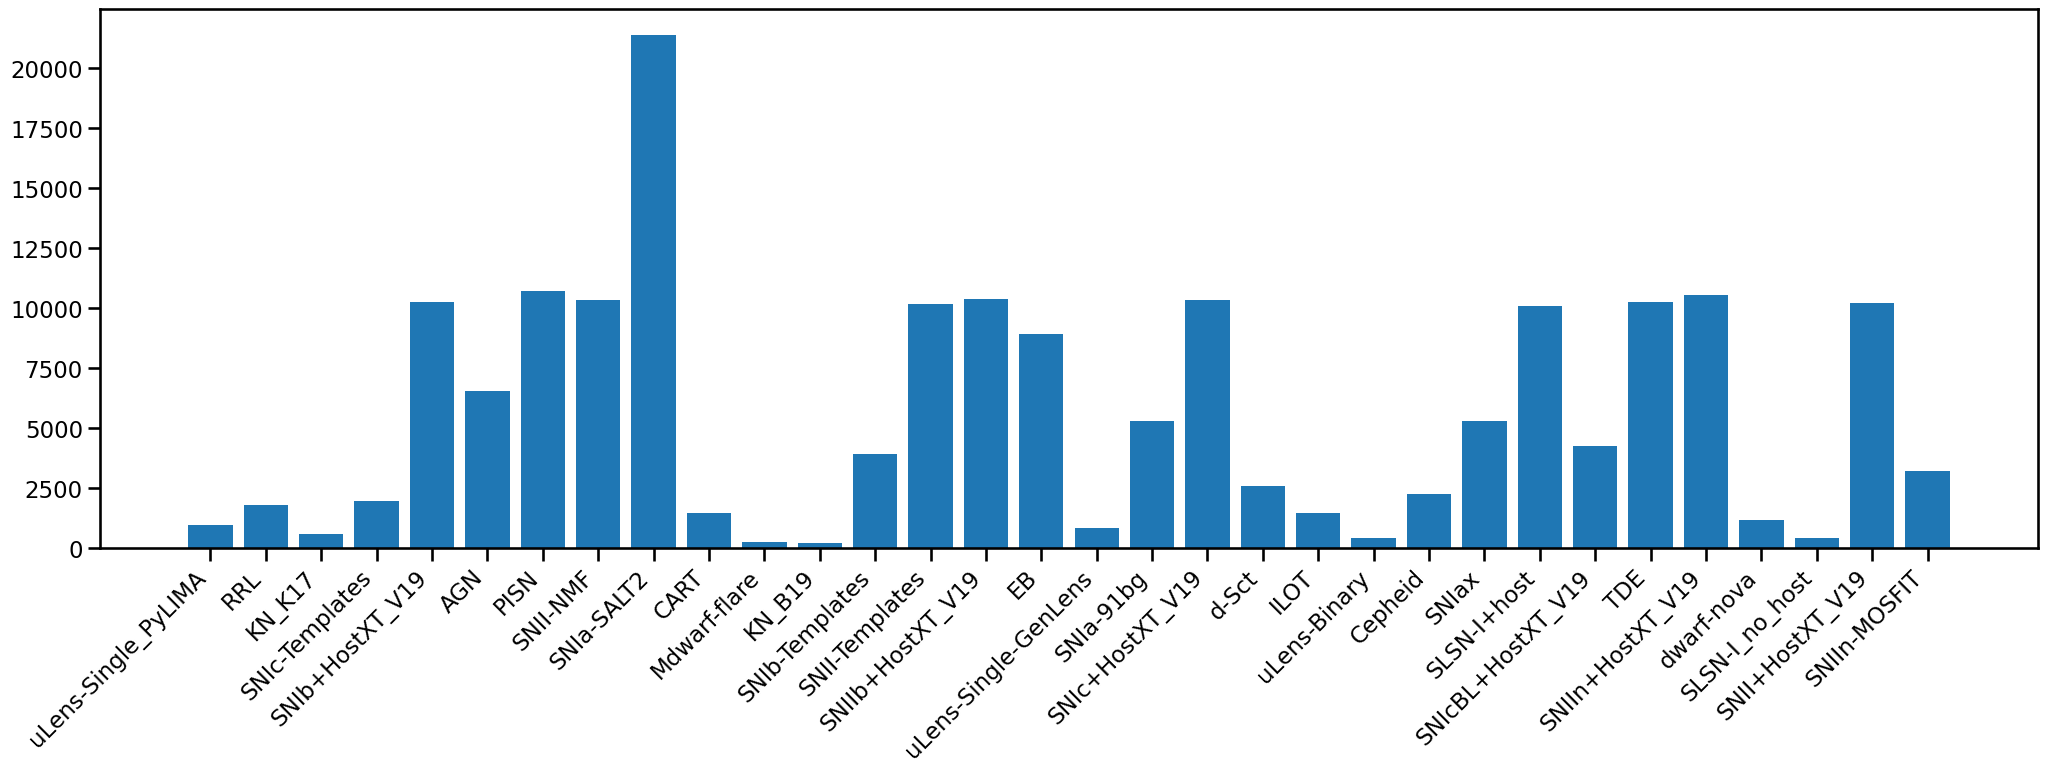

In [7]:
#create a dictionary of the counts for each type
Counts = Counter(df['Type'])

#plot them as a bar graph
sns.set_context("talk")
plt.figure(figsize=(25, 7))
plt.bar(*zip(*Counts.items()))
plt.xticks(rotation=45, ha='right')
plt.show()

The training set includes a variety of different transient types, including:

* Secular, Pulsating and Eruptive Variable Stars
* Tidal Disruption Events
* Kilonovae
* Supernovae of different types (SN Ia/II/Ibc, PISN)
* Active Galactic Nuclei
* Microlensing Events
* Eclipsing Binaries

Note how imbalanced the dataset is! This is by design - we find transients at dramatically different rates, some because they happen less often in the universe and others because they are fainter than others (or happen much further away). In this case, we find more SNe Ia than any other classes becuase they are both relatively common and extremely bright!

Note that this is 10% of the _training set_, which doesn't have a _completely_ representative sample of events. If you're training an algorithm to learn what each of these transients look like, it's useful to have more events than you might actually see in nature (especially for rarer classes). Still, we tried to include more events of common classes and few events of rare classes. More details on these models can be found in the original plasticc papers at https://arxiv.org/pdf/1903.11756.pdf. 

What properties do we have for these transients?

In [8]:
df.columns.values

array(['SNID', 'true_redshift', 'MWEBV', 'hostgal_ellipticity',
       'discovery_date', 'RA', 'Dec', 'hostgal_photoz',
       'hostgal_photoz_err', 'hostgal_logsfr', 'hostgal_logmass',
       'hostgal_mag_u', 'hostgal_mag_g', 'hostgal_mag_r', 'hostgal_mag_i',
       'hostgal_mag_z', 'hostgal_mag_Y', 'MJD', 'Flux', 'Mag', 'Mag_Err',
       'Flux_Err', 'Type', 'Band', 'T_FWHM'], dtype=object)

Some of these properties wll not actually be reported by the Rubin Observatory - for example, the derived properties of the host galaxy cannot be easily calculated from photometry alone. But many of these will be (photo-z, which we'll talk about in a bit, and the the coordinates where we saw the transient take place). Let's take a look at the coordinates:

In [9]:
#astronomy units are funny - east and west are switched because you look OUT at the celestial sphere 
#rather than in like you would for the surface of the Earth.
ra = coord.Angle(-df['RA'].values*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df['Dec'].values*u.degree)

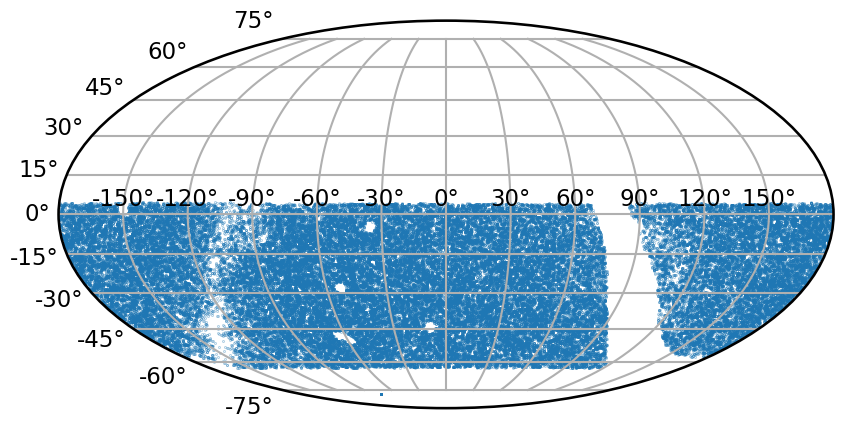

In [10]:
#let's plot a map projection of where in the sky these events happen:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian, s=0.05)
ax.grid(True)
plt.show()

What do we notice? 

Compare this with the planned survey strategy of Rubin's LSST: 

![](media/RubinLSST.png)

(Credit: Guy et al., 2022)

Next, do we expect all transients to be found in similar locations on the sky? Why or why not? Where does the galactic plane fall?

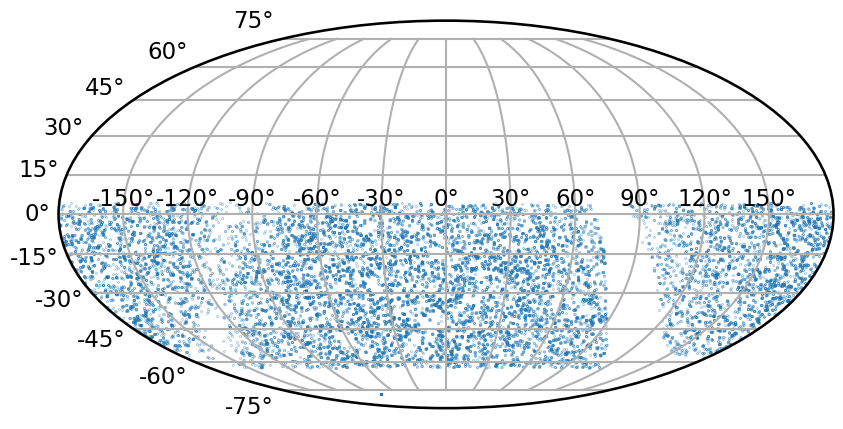

In [11]:
def convert_mollweide(ra, dec):
    ra = coord.Angle(-ra*u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(dec*u.degree)
    return ra, dec
    
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
    
for transient_class in ['SNIa-SALT2']:
    subset = df.loc[df['Type'] == transient_class]
    ra, dec = convert_mollweide(subset['RA'].values, subset['Dec'].values)
    ax.scatter(ra.radian, dec.radian, s=0.05)

What is causing the big gap on the right and left sides? Hint: here's the path that the Milky Way traces in this projection: 

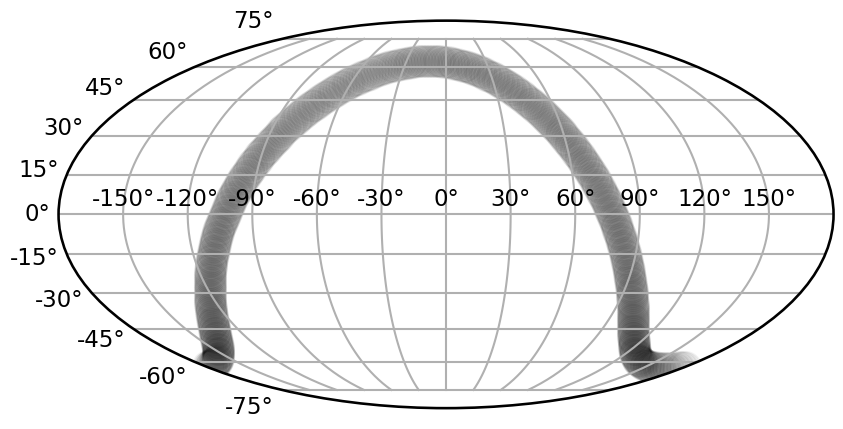

In [12]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)

lon_array = np.arange(0,360)
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(0))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
    RA = eq_array[:,0]
    Dec = eq_array[:,1]
    
RA, Dec = convert_mollweide(RA, Dec)
ax.scatter(RA.radian, Dec.radian, s=500, alpha=0.05, c='k')
plt.show()

We avoid looking for things outside our galaxy along the Galactic plane, where there's so many stars and so much dust _from_ our galaxy that there isn't much to see. We're also excluding the deep drilling fields in this dataset, as we mentioned. Here's a more detailed picture of the planned survey:

<img src="media/skymap.jpeg"  width="80%" height="40%">
(Credit: LSST Corporation)

Now let's look at the photometry, or how an event changes brightness over time. We call this an event's _light curve_.

# 1. Plot a single light curve.

Let's take the first event in the sample, and plot it. 

In [13]:
transient1 = df.iloc[0]
print(transient1['Type'])

uLens-Single_PyLIMA


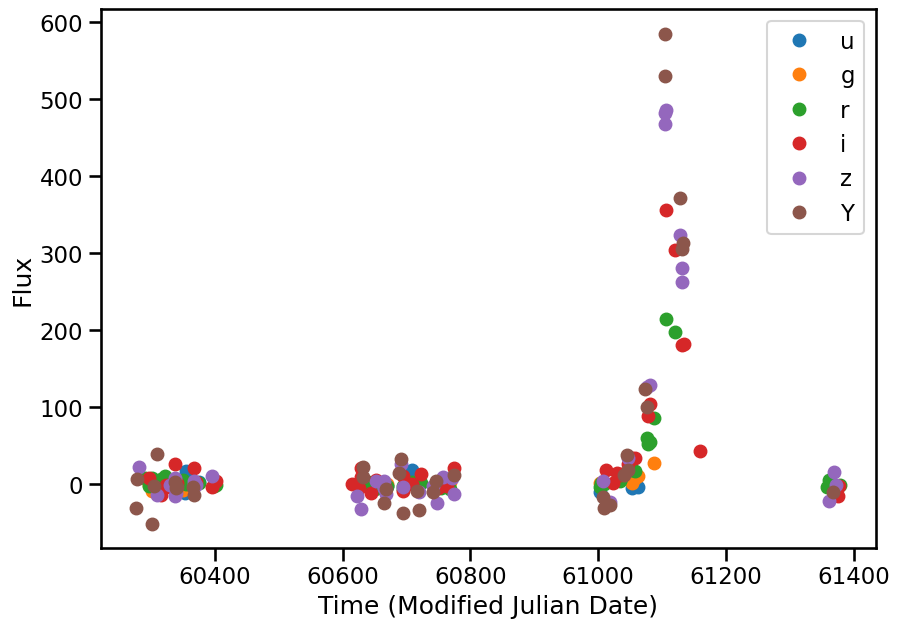

In [14]:
plt.figure(figsize=(10,7))
for band in 'ugrizY':
    idx = transient1['Band'] == band
    plt.plot(transient1['MJD'][idx], transient1['Flux'][idx], 'o', label=band)
plt.legend();
plt.xlabel("Time (Modified Julian Date)");
plt.ylabel("Flux");

We can see that 

A) The event gets brighter between MJD 610000 and 61200,

B) A lot of observations have around 0 flux before and after the event took place, and 

C) There are gaps in between sets of observations. This is a reflection of the observing strategy of the telescope - how often our telescope looks at the same part of the sky.

# 2. Now let's plot many i-band light curves of a single class.

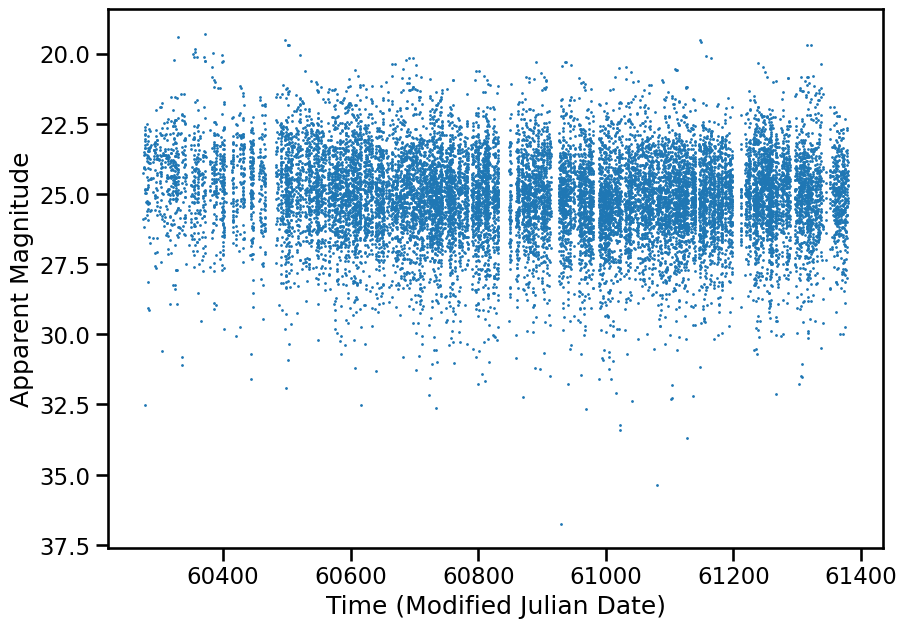

In [15]:
SNIa_1k = df.loc[df['Type'] == 'SNIa-SALT2'].sample(1000).reset_index()
plt.figure(figsize=(10,7))
for idx, row in SNIa_1k.iterrows():
    ii = row['Band'] == 'i'
    plt.plot(row['MJD'][ii], row['Mag'][ii], 'o', c='tab:blue', ms=1)
plt.gca().invert_yaxis()
plt.xlabel("Time (Modified Julian Date)")
plt.ylabel("Apparent Magnitude")
plt.show()

This is pretty messy...Is there a more useful way to compare light curves? What if we line them all up pretending that they all happened at the same time? This might help us to compare how quickly each one brightens and dims, which ones end first, and how bright they get relative to each other.

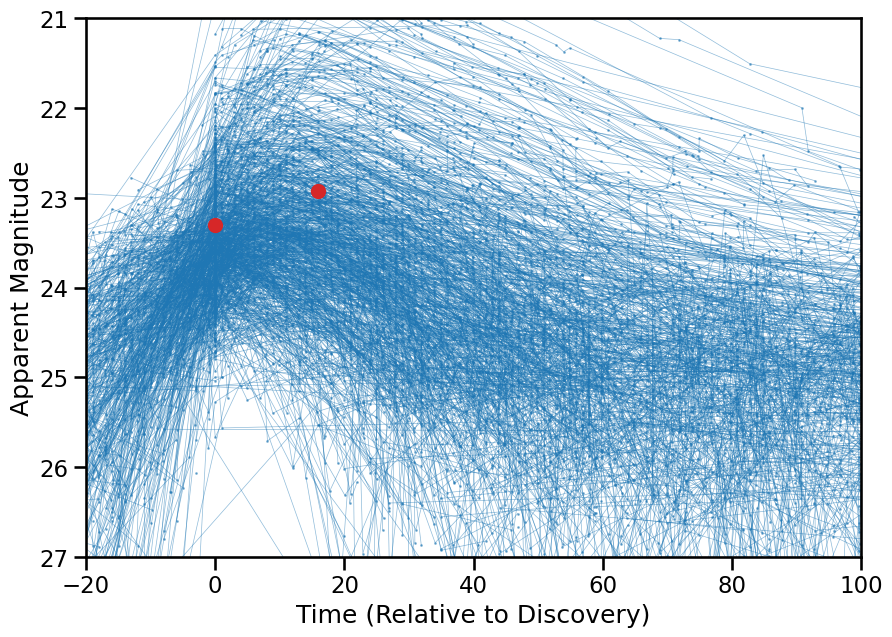

In [16]:
plt.figure(figsize=(10,7))
for idx, row in SNIa_1k.iterrows():
    ii = row['Band'] == 'i'
    discovery_date = row['discovery_date']
    plt.plot(row['MJD'][ii]-discovery_date, row['Mag'][ii], 'o-', c='tab:blue', lw=0.5, alpha=0.5, ms=1)

#plot just one
SN = 20

ii = SNIa_1k.loc[SN, 'Band'] == 'i'
discovery_date = SNIa_1k.loc[SN, 'discovery_date']
plt.plot(SNIa_1k.loc[SN, 'MJD'][ii]-discovery_date, SNIa_1k.loc[SN, 'Mag'][ii], 'o', c='tab:red', ms=10, zorder=100)


plt.xlim((-20, 100))
plt.ylim((27, 21))
plt.xlabel("Time (Relative to Discovery)")
plt.ylabel("Apparent Magnitude")
plt.show()

We can see how much variation there is even with SNe Ia, not just in how dim or bright they are but in how quickly they decline (and I don't show this, but in their color too). One caveat here is that I'm not correcting for Galactic extinction, which reddens the light from transients as you look through more and more dust from our Galaxy.

Let's do this with different types of phenomena - plot the light curves of a few different events in our sample:

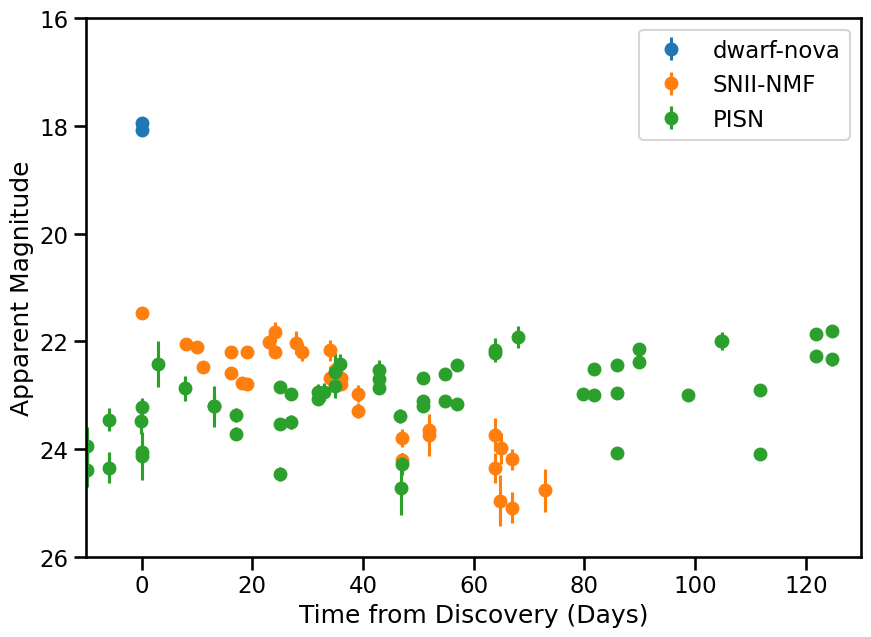

In [17]:
# pick the second event of each class (these happened to look pretty)
idx_event = 2

plt.figure(figsize=(10,7))
# let's look at three very different types of events - dwarf novae, when one material accretes material from a secondary; SN II,
# when a young star explodes; and PISNe, a theoretical explosion that can only occur in the most massive stars that ever lived.
for event in ['dwarf-nova', 'SNII-NMF', 'PISN']:
    subset = df[df['Type'] == event]
    ii = subset.iloc[idx_event]['Mag_Err'] < 0.5
    discovery_date = subset.iloc[idx_event]['discovery_date']
    phase = subset.iloc[idx_event]['MJD'][ii] - discovery_date
    mag = subset.iloc[idx_event]['Mag'][ii]
    magerr = np.abs(subset.iloc[idx_event]['Mag_Err'])[ii]
    plt.errorbar(phase, mag, magerr, fmt='o', label=event)
plt.gca().invert_yaxis()
plt.legend()
plt.xlim((-10, 130))
plt.ylim((26, 16));
plt.xlabel("Time from Discovery (Days)")
plt.ylabel("Apparent Magnitude");

Think of the intuition behind this - this is, in any band, how bright each event is relative to when we first discovered it. The fact that we can distinguish between events in this space suggests that 
this is a useful discriminator between phenomena - how rapidly an event brightens and dims, how bright it gets, whether it changes color...These have become essential for identifying and classifying events using machine-learning algorithms. Let's look at the typical light curve of supernovae of different classes:

![](media/SNe.png)

Much of the time, people will calculate many features _from_ the light curves instead of using the light curves directly. We'll do a bit of that below. 

# 3. Plot the timescales of transients in our sample.

Now let's look at how long transients in our sample tend to last. I've pre-computed T_FWHM, the time it takes from when it reaches half its maximum brightness to when it dims to that same level again. This is just to get some standard measurement for timescale (especially when some events brighten and dim quickly, whereas others brighten quickly and dim slowly, depending on the physics producing the event). There are others measurements you could use. 

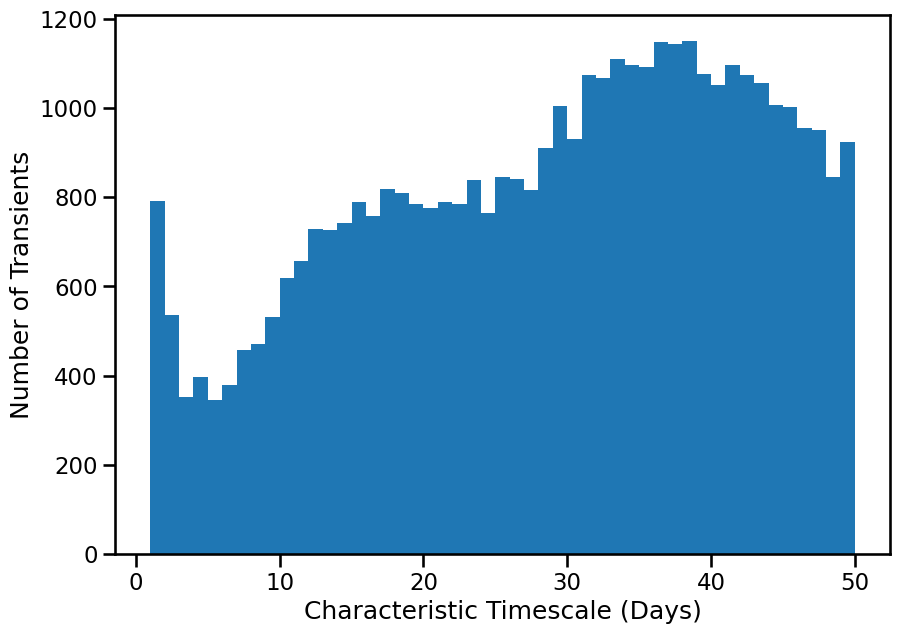

In [18]:
plt.figure(figsize=(10,7))
plt.hist(df['T_FWHM'], bins=np.linspace(1, 50));
plt.xlabel("Characteristic Timescale (Days)");
plt.ylabel("Number of Transients");

Anything particularly interesting to note here? There are at least 3 peaks - maybe more! One around a few days, one 10-20 days, and one around 40 days. This points to specific classes having different timescales, which hints at their emission processes.

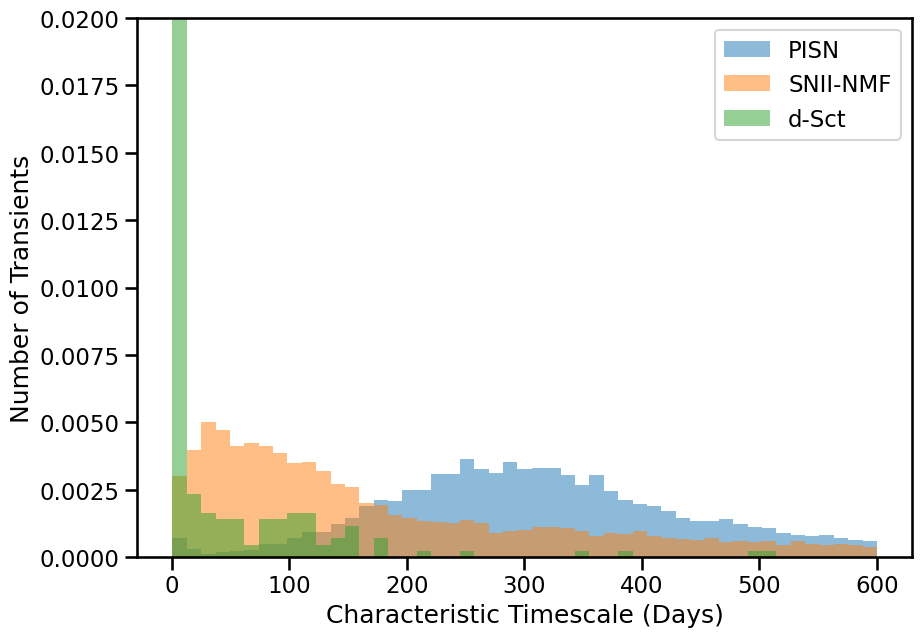

In [19]:
plt.figure(figsize=(10,7))
for transient_class in ['PISN', 'SNII-NMF', 'd-Sct']:
    plt.hist(df.loc[df['Type'] == transient_class, 'T_FWHM'], bins=np.linspace(0.5, 600), alpha=0.5, label=transient_class, density=True);
    plt.xlabel("Characteristic Timescale (Days)")
    plt.ylabel("Number of Transients");
plt.ylim((0, 0.02))
plt.legend();

Remember again how long-lasting the PISNe are and how much rapidly-evolving the SNe II are! This is just the timescale - machine learning methods in practice use a million different properties of the light curve, each meaning slightly different things. Just check out https://alerce.science/features/!

Many of these are explained in more detail (and their value for classification) at https://github.com/LSSTDESC/plasticc-kit/blob/master/plasticc_classification_demo.ipynb. 

## 4. Now, get the redshifts of the transients. What does the distribution look like? 
Photometric redshifts are how we estimate a galaxy's distance from its color. Because the Universe is expanding, galaxies further from us should experience a greater Doppler shift and its light should be shifted more toward red wavelengths. 

These are a massive area of active research, with lots of pitfalls - in general far away galaxies are redder, but dustier galaxies are also redder, and  galaxies with many old stars are also redder). So there are lots of tricks to estimating how far away a galaxy is just by its color and brightness. 

People devote their entire careers to this kind of thing! 

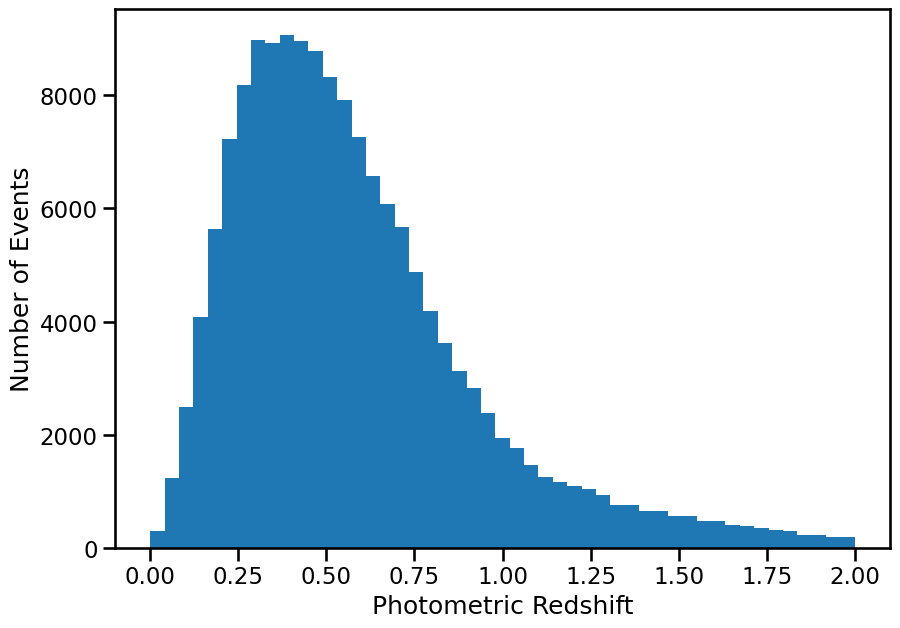

In [20]:
plt.figure(figsize=(10,7))
plt.hist(df['hostgal_photoz'], bins=np.linspace(0, 2));
plt.xlabel("Photometric Redshift");
plt.ylabel("Number of Events");

What do we notice? 

The distribution goes from 0 to 1 and drops off shortly thereafter. One of the most impressive things about the Rubin observatory is going to be its ability to find distant supernovae.

How well do we do with these redshift estimates?

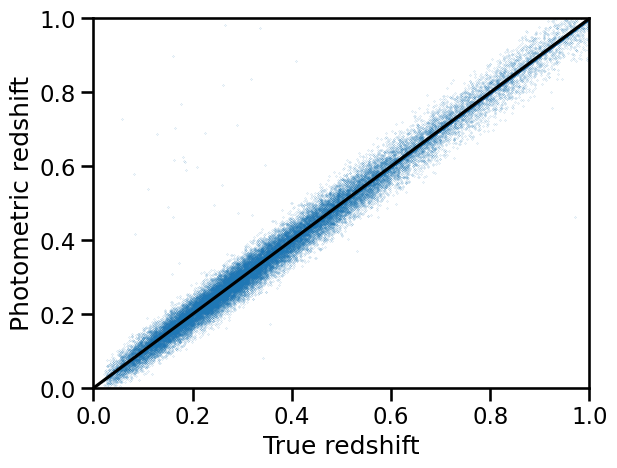

In [21]:
plt.plot(df['true_redshift'], df['hostgal_photoz'], 'o', ms=0.1)
plt.xlim((0, 1))
plt.ylim((0, 1));
plt.plot(np.linspace(0, 1), np.linspace(0, 1), c='k');
plt.xlabel("True redshift")
plt.ylabel("Photometric redshift");

These are simulated redshifts, so the relationship looks tight. In reality, the relationship can be a lot messier:

![](media/photoz_plotting.png)

(from https://www.astroml.org/examples/learning/plot_neighbors_photoz.html).

### 5. Now, let's use the photometric redshift to compute a distance. 
It's important to know that we have to assume a cosmology here to go from redshift to distance. This is an important assumption that we make and could be wrong! Has anyone heard of the Hubble Tension? But our current cosmological model is doing very, very well, so we won't be that far off in any case. Further down, we go the other direction, and use supernovae to constrain our cosmological model.

In [22]:
from astropy.cosmology import w0wzCDM 

#redshift to distance - note that we have to assume a cosmology here!
cosmology = w0wzCDM(H0=70, Om0=0.3, Ode0=0.7, w0=-1.0, wz=0.0)

#create a dummy column for now in our table
df['Abs_Mag'] = df['Mag'].copy()

#loop over the dataset and convert redshift to distance
for idx, row in df.iterrows():
    z = row['hostgal_photoz'] * cu.redshift
    d_pc = z.to(u.pc, cu.redshift_distance(cosmology)) 
    M = -5 * np.log10(d_pc/(10*u.pc)) + row['Mag']
    df.at[idx, 'Abs_Mag'] = M
    
    #get the minimum absolute magnitude to get the peak brightness
    Peak_Abs_Mag = np.nanmin(M)
    df.at[idx, 'Peak_Abs_Mag'] = Peak_Abs_Mag

/Users/alexgagliano/mambaforge/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1132: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
<__array_function__ internals>:180: RuntimeWarning: All-NaN axis encountered
/Users/alexgagliano/mambaforge/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1132: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]
<__array_function__ internals>:180: RuntimeWarning: All-NaN axis encountered


And the distribution?

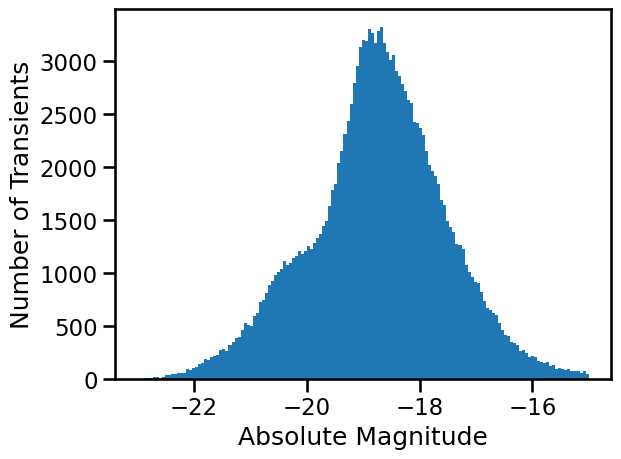

In [23]:
plt.hist(df['Peak_Abs_Mag'].values, bins=np.linspace(-23, -15, 150));
plt.xlabel("Absolute Magnitude");
plt.ylabel("Number of Transients");

We see a peak around -19, which is where most SNe Ia peak, but there is also some bimodality - clearly there are some brighter events in our sample.

We can see that there are some differences in timescale, and differences in brightness. Let's tie those two ideas together by making a plot of one versus the other. 

What if we just want to separate out one classs? 

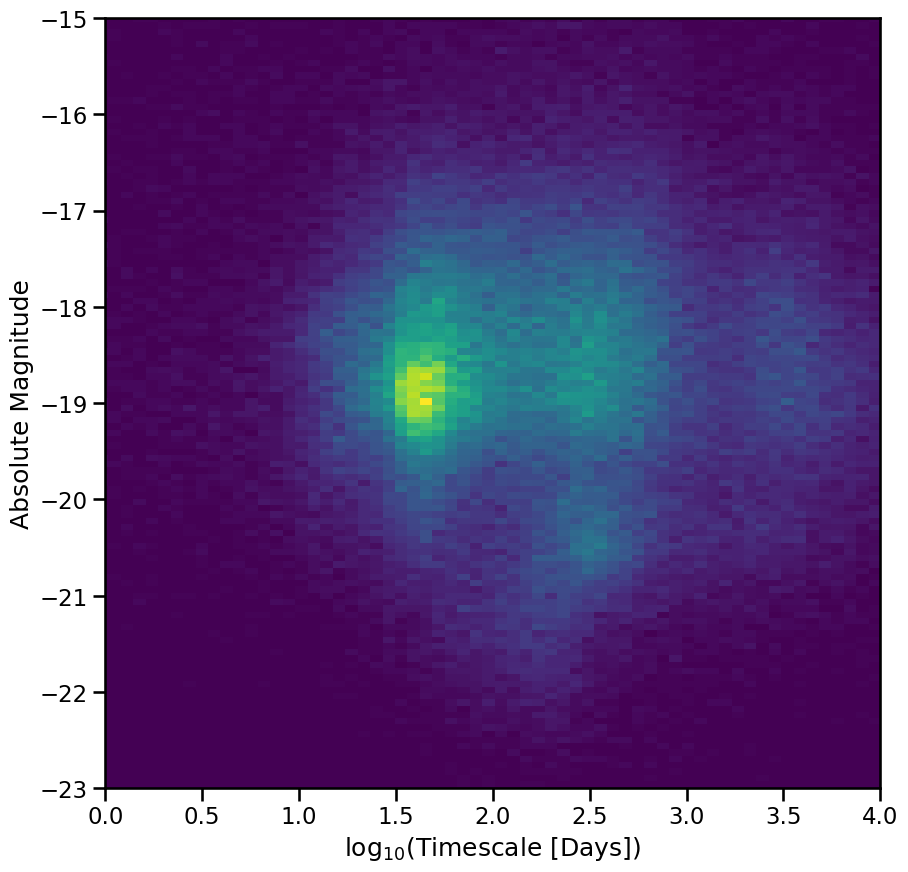

In [24]:
import matplotlib.colors as mcolors

extragalactic = df.dropna(subset=['T_FWHM', 'Peak_Abs_Mag'])

plt.figure(figsize=(10,10))
plt.hist2d(np.log10(extragalactic['T_FWHM']), extragalactic['Peak_Abs_Mag'], bins=(1000, 250), norm=mcolors.PowerNorm(0.8));
#plt.plot(np.log10(extragalactic.loc[extragalactic['Type'] == 'PISN', 'T_FWHM']), extragalactic.loc[extragalactic['Type'] == 'PISN', 'Peak_Abs_Mag'], 'o', c='w', mec='w', ms=0.5, alpha=0.5)
#plt.axvline(x=2.2, ls='--', c='tab:red')
#plt.axhline(y=-19.7, ls='--', c='tab:red')
plt.xlim((0, 4));
plt.ylim((-23, -15));
plt.xlabel(r"log$_{10}$(Timescale [Days])")
plt.ylabel("Absolute Magnitude");

What do we notice about this plot?

# 6. What do the properties of the host galaxies look like? 
There are a million open questions about how stars explode, and one of the ways that we can gain more insight is by looking into the explosion environment. This works because different explosions come from different stars, and galaxies are made up of old and young, massive and not-so-massive stars in varying proportions. This has dramatic consequences for how the galaxies look: 

<img src="media/typesOfGalaxies.jpeg"  width="60%" height="40%">

Let's look at three different types of explosion here.

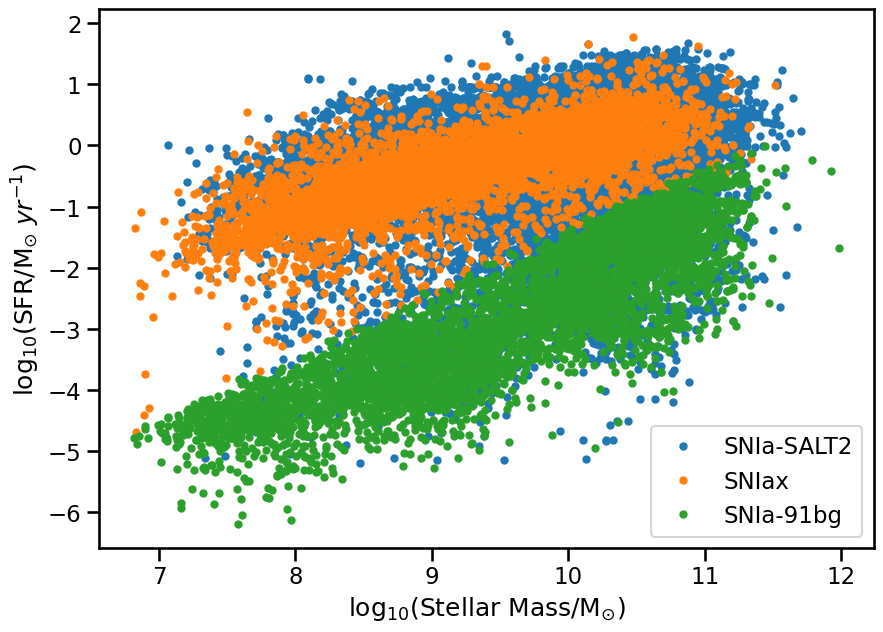

In [25]:
plt.figure(figsize=(10,7))
for transient_class in ['SNIa-SALT2','SNIax', 'SNIa-91bg']:
    plt.plot(df.loc[df['Type'] == transient_class, 'hostgal_logmass'], df.loc[df['Type'] == transient_class, 'hostgal_logsfr'], 'o', ms=5, label=transient_class, zorder=100);
plt.legend()
plt.xlabel(r"log$_{10}$(Stellar Mass/M$_{\odot}$)");
plt.ylabel(r"log$_{10}$(SFR/M$_{\odot}\;yr^{-1}$)");

SNe Iax happen more often in highly star-forming galaxies - see page 10 of https://arxiv.org/pdf/1707.01110.pdf! SNIa-91bg-like SNe prefer ellipticals with mostly old stars - see https://arxiv.org/pdf/1906.10501.pdf. 

We've put in a lot of effort to make these correlations realistic, so that they can be used to better classify transients when light curve information alone isn't enough. This is an active area of research - reach out if you'd like to get involved! 

In reality, Rubin dataset will not be analyzed on-disk in its entirety (or even a large fraction) - it will be analyzed remotely using alert brokers. See e.g., https://antares.noirlab.edu/loci if you'd like to look at how the data will be presented, and how you can start analyzing it.

How are the brokers doing on the ELAsTiCC data? Check out https://desc-tom.lbl.gov/elasticc/ to find out!

That's the end of this tutorial! One final point - these simulations are based on what we think we'll find. Every time we run a revolutionary survey, we find unexpected things. LSST is no different. To try and plan for the unexpected, ELAsTiCC data also contains at least a few events that we've never seen before in nature - including a few theorized technosignatures. After months of streaming the data, _not a single team has found this signal_. You can build new tools for the search as a graduate student, and help us to make these groundbreaking discoveries.

Questions? Comments? Reach out anytime at gaglian2@illinois.edu.

# Extra credit. A very basic cosmological analysis with SNe Ia
One of the big drivers of Rubin Observatory is to understand the nature of dark energy, which we believe is a field that pushes things apart. Type Ia supernovae are a great way to do this - we know very well how they evolve, because it's remarkably constant throughout the Universe. This is actually still a mystery - models for their explosion suggest that the explosions should be more different than they are. Anyway, the fact that they're predictable is great for us, because when one explodes we can calculate how far away it is from how dim it is relative to our expectations. Type Ia supernovae confirmed that the universe's expansion was accelerating in the 90's, which led to the 2011 Nobel Prize in Physics.

Let's look at how this works in a little more detail. What is the absolute brightness of a type Ia supernova in our sample, when we assumed a cosmological model?

One more thing - let's calculate the maximum flux in r-band. This will be useful to us later on.

In [26]:
for idx, row in df.iterrows():
    ii = row['Band'] == 'r'
    rMagMin = np.nanmin(row['Mag'][ii])
    df.at[idx, 'rMagMin'] = rMagMin

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_8387/3687705887.py:3: RuntimeWarning: All-NaN slice encountered
  rMagMin = np.nanmin(row['Mag'][ii])


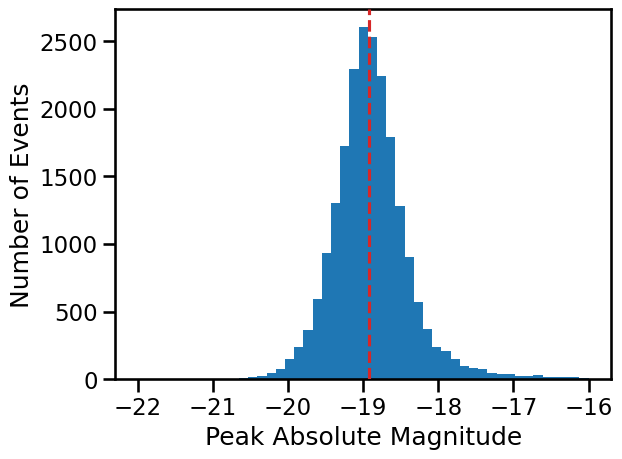

In [27]:
SNIa = df.loc[df['Type'] == 'SNIa-SALT2']

plt.hist(SNIa['Peak_Abs_Mag'], bins=np.linspace(-22, -16));
plt.axvline(x=np.nanmedian(SNIa['Peak_Abs_Mag']), ls='--', c='tab:red', zorder=100)
plt.xlabel("Peak Absolute Magnitude");
plt.ylabel("Number of Events");

Pretty consistent. What if we don't want to assume a cosmological model - we want to test one? Let's assume for simplicity that all SNe Ia have their maximum brightness at exactly M = -19.

In [28]:
Mtrue = -19.0

Now we calculate what's called a _distance modulus_, the difference between the observed and the absolute brightness of an object. 

In [29]:
SNIa['dm'] = SNIa['rMagMin'] - Mtrue

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_8387/168499013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNIa['dm'] = SNIa['rMagMin'] - Mtrue


One more term that we have to add (in our simple model) is part of what's called a "k-correction" - and this accounts for how light is redshifted more the further away the supernova is. 

In [30]:
SNIa['dm'] += 2.5*np.log10(1+SNIa['hostgal_photoz'])

/Users/alexgagliano/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_8387/4081549818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SNIa['dm'] += 2.5*np.log10(1+SNIa['hostgal_photoz'])


One of the big drivers of Rubin science is understanding the nature of dark energy.

In [31]:
z = np.linspace(0, 1)

from astropy.cosmology import w0wzCDM

cosmo1 = w0wzCDM(H0=70, Om0=0.3, Ode0=0.7, w0=-1.0, wz=0.2)
cosmo2 = w0wzCDM(H0=70, Om0=0.3, Ode0=0.7, w0=-1.0, wz=0.0)

dm_LambdaCDM1 = cosmo1.distmod(z);
dm_LambdaCDM2 = cosmo2.distmod(z);

/Users/alexgagliano/mambaforge/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


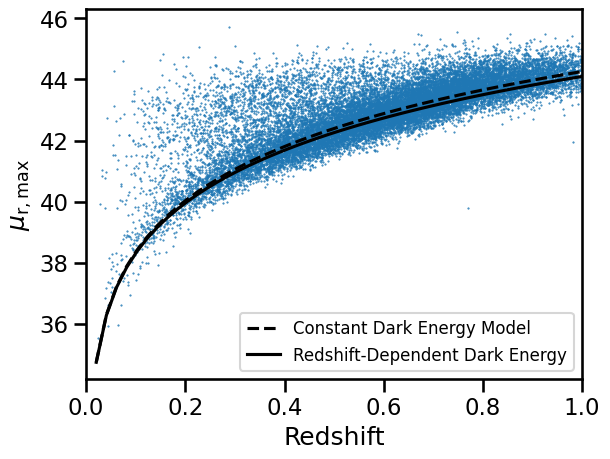

In [32]:
plt.plot(z, dm_LambdaCDM1, ls='--', c='k', zorder=100, label='Constant Dark Energy Model')
plt.plot(z, dm_LambdaCDM2, c='k', zorder=100, label='Redshift-Dependent Dark Energy')
plt.plot(SNIa['hostgal_photoz'], SNIa['dm'], 'o', ms=0.5);
plt.ylabel(r"$\mu_{\rm{r,max}}$");
plt.xlabel("Redshift");
plt.legend(fontsize=12);
plt.xlim((0, 1));

A pretty good match! The difference between the two models is small compared to the supernova's scatter in the way that we've done it, but there are many ways to reduce that scatter. How?

1. A lot of outlier rejection from photometry checks and model fitting.
2. Type Ia supernovae are not as standard as we suggested, and there are relationships between their color and brightness that we account for before making a plot like this. 
3. We also made some assumptions in our k-correction that are not strictly true.
4. Finally, we're looking at supernovae in the Wide-Fast-Deep survey. In the Deep Drilling Fields, supernovae will be observed at much higher cadence and wiht higher S/N observations, which will lead to better estimates of max brightness and color corrections.
5. Improve our redshift estimation for a better k-correction! There are many, many machine learning algorithms that are being developed for this purpose - see just a few from https://arxiv.org/pdf/2001.03621.pdf: 

![](media/PhotozCodes.png)